# Top-level imports

In [1]:
%load_ext autoreload
%autoreload 2

#### import packages - setup

In [2]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from sklearn import metrics

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
data_dir = 'data/'

In [5]:
data_files = os.listdir(data_dir)
data_files.sort()
data_files

['BroughtonSeaLice_fishData.csv',
 'BroughtonSeaLice_fishInfo.csv',
 'BroughtonSeaLice_siteData.csv',
 'BroughtonSeaLice_siteInfo.csv',
 'DFOSeaLice_Data.csv',
 'DFOSeaLice_Info.csv',
 'IndustrySeaLice_Data.csv',
 'IndustrySeaLice_Info.csv',
 'README.md']

#### Wild data

In [6]:
fish_data = pd.read_csv(f'{data_dir}BroughtonSeaLice_fishData.csv', encoding='ISO-8859-1')
site_data = pd.read_csv(f'{data_dir}BroughtonSeaLice_siteData.csv', encoding='ISO-8859-1')

/usr/local/Cellar/ipython/7.8.0/libexec/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
fish_info = pd.read_csv(f'{data_dir}BroughtonSeaLice_fishInfo.csv', encoding='ISO-8859-1')
site_info = pd.read_csv(f'{data_dir}BroughtonSeaLice_siteInfo.csv', encoding='ISO-8859-1')

#### Farm data

In [8]:
dfo_data = pd.read_csv(f'{data_dir}DFOSeaLice_Data.csv')
dfo_info = pd.read_csv(f'{data_dir}DFOSeaLice_Info.csv')

In [9]:
industry_data = pd.read_csv(f'{data_dir}IndustrySeaLice_Data.csv', encoding='ISO-8859-1', low_memory=False)
industry_info = pd.read_csv(f'{data_dir}IndustrySeaLice_Info.csv', encoding='ISO-8859-1', low_memory=False)

# Data/Feature Engineering

Possible input scenarios
- 2001-2018: We have to trust that the model can work with the large amounts of NaN values in earlier years, both in wild data and no farmed data until 2011 
- 2003-2018: 2003 is the first year we have data starting in March


## Setting overall constants

Things to set here 
- Years to analyse
- Within-season date range
- Linear scaling factors (*return to this*)
- Accepted ranges
- Resampling dates (*return to this*)

In [10]:
analysis_years = list(range(2003, 2018))

In [11]:
analysis_months = list(range(3, 8))

## Setting up response

### Unified adult count
This is one possible response

In [12]:
fish_data.columns

Index(['fish_id', 'site_id', 'year', 'day', 'month', 'location', 'fish_num',
       'species', 'length', 'height', 'Lep_cope', 'chalA', 'chalB',
       'Lep_PAmale', 'Lep_PAfemale', 'Lep_male', 'Lep_nongravid', 'Lep_gravid',
       'Caligus_cope', 'Caligus_mot', 'Caligus_gravid', 'unid_cope',
       'chal_unid', 'unid_PA', 'unid_adult', 'chal_scar', 'pred_scar',
       'mot_scar', 'hem', 'mateguarding', 'eroded_gill', 'white_eye',
       'blue_blotches', 'pinched_belly', 'scales', 'comments'],
      dtype='object')

In [13]:
adult = fish_data[['Lep_PAmale', 'Lep_PAfemale', 
                   'Lep_male', 'Lep_gravid',
                   'Lep_nongravid', 'unid_PA',
                   'unid_adult']].sum(axis=1)

In [14]:
fish_data_date = pd.to_datetime(fish_data[['year', 'day', 'month']])

In [15]:
response = pd.DataFrame({'count':adult.values, 
                         'location':fish_data['location'].values,
                         'datetime': fish_data_date})

In [16]:
response_glacier = response[response['location'] == 'Glacier']

In [17]:
# resample by week for average
Y_glacier = response_glacier.resample('W', on='datetime', label='left').apply(np.nanmean)

## Setting up inputs - wild data

In [18]:
# non-motile lice
juvenile = pd.DataFrame(fish_data[['Lep_cope', 'chalA',
                      'chalB', 'Caligus_cope',
                      'unid_cope', 'chal_unid']].sum(axis=1)).rename({0: 'count'}, axis=1)
juvenile['datetime'] = fish_data_date
juvenile['location'] = fish_data['location']

In [19]:
X_wild_juv = juvenile.groupby('location').resample('W', on='datetime', label='left').apply(np.nanmean)

In [20]:
# temperature
site_data['datetime'] = pd.to_datetime(site_data[['year', 'month', 'day']])

In [21]:
X_wild_temp = site_data[['datetime', 'temp', 'location']]
X_wild_temp = X_wild_temp.groupby('location').resample('w', on='datetime', label='left').apply(np.nanmean)

## Setting up inputs - farm data

- Implementing treatments *may* not be a priority - I'll have to do some extensive testing on this
- There are of course concerns with using the industry counts as they *may* be of very low quality (I need to look much more extensively into this data)
    - Should look into what kind of predictive differences including/excluding these has 

In [22]:
industry_data['Day'] = 1
month_map = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
industry_data['month'] = industry_data['Month'].map(month_map)
industry_data['datetime'] = pd.to_datetime(industry_data[['Year', 'month', 'Day']])

X_industry = industry_data[['datetime',
                            'Site Common Name',
                            'Average L. salmonis motiles per fish',
                            'Average chalimus per fish']]
X_industry = X_industry.groupby('Site Common Name').resample('W', on='datetime', label='left').mean()

### Forming array for model input

In [23]:
arrays_to_stack = []

for year in analysis_years:
    juv_sub = X_wild_juv[(X_wild_juv.index.get_level_values(1).year == year) & 
                         X_wild_juv.index.get_level_values(1).month.isin(analysis_months)].unstack().T.values
    temp_sub = X_wild_temp[(X_wild_temp.index.get_level_values(1).year == year) & 
                           X_wild_temp.index.get_level_values(1).month.isin(analysis_months)].unstack().T.values
    
    year_array = np.concatenate((juv_sub, temp_sub), axis=1)
    if year_array.shape[0] == 21:
        year_array = np.append(year_array, np.full(6, np.nan).reshape(1, 6), axis=0)
    arrays_to_stack.append(year_array)
    
test_X = np.stack(arrays_to_stack, axis=0)

In [24]:
test_X.shape

(15, 22, 6)

In [25]:
arrays_to_stack = []

for year in analysis_years:
    year_Y = Y_glacier[(Y_glacier.index.year == year) & 
                       Y_glacier.index.month.isin(analysis_months)].values
    if year_Y.shape[0] == 21:
        year_Y = np.append(year_Y, np.nan)
        year_Y = year_Y.reshape(22, 1)
    arrays_to_stack.append(year_Y)
    
test_Y = np.stack(arrays_to_stack, axis=0)
test_Y = test_Y

In [26]:
test_Y.shape

(15, 22, 1)

# Experimenting with models

## Import packages and set up functions

Write normalising functions here (let's go with MinMaxScaling for future implementations)

## Setup Data

### Normalise and fill NAs

In [27]:
X_mean = np.nanmean(test_X, axis=1)
for i in range(0, X_mean.shape[0]):
    test_X[[i]] = test_X[[i]] - X_mean[[i]]
X_std = np.nanstd(test_X, axis=1)
for i in range(0, X_std.shape[0]):
    test_X[[i]] = test_X[[i]] - X_std[[i]]
test_X = np.nan_to_num(test_X)

In [28]:
Y_mean = np.nanmean(test_Y, axis=1)
for i in range(0, Y_mean.shape[0]):
    test_Y[[i]] = test_Y[[i]] - Y_mean[[i]]
Y_std = np.nanstd(test_Y, axis=1)
for i in range(0, Y_std.shape[0]):
    test_Y[[i]] = test_Y[[i]] - Y_std[[i]]
test_Y = np.nan_to_num(test_Y)

### Split into train and test

In [29]:
train_X = test_X[:-3]
train_Y = test_Y[:-3]

eval_X = test_X[-3:]
eval_Y = test_Y[-3:]

## Baseline

### Overall Avg

### Naive seasonal

In [75]:
def naive_seasonal(year: int, reference_data: pd.DataFrame):
    '''
    Naive seasonal model
    This model takes a year to be predicted in and returns the last known year's values
    
    year: Year to be predicted
    reference_data: Pandas dataframe of the test/input Y data, must have a DatetimeIndex index
    '''
    
    
    pred_subset = reference_data[reference_data.index.year == year]
    preds = pred_subset[pred_subset.index.month.isin(analysis_months)]
    
    return(np.array(preds))

### ARIMA

## Non-parametric

Some high level notes
- This analysis is very rough and is in no way final!!!
- The normalising, feature engineering, etc. is probably the roughest part of all of this. I don't expect it to have an effect on model choice but by no means should the input/output data be taken verbatim as what I intend to use
- Optimizers: some reading has shown that RMSprop is the suggested optimiser for RNNs, this also coincides with François Chollet's use of optimisers so for now I am going with this one for RNNs and ADAM as the default for all others. This requires further research!
- Reference points: 
     - ARIMA
     - Mean & SD

### LSTM

Long short-term memory (LSTM)

This model is the most advanced RNN for sequential data, so the highest potential upside in gaining value from features but may also be overkill so make sure to compare it to some other RNN baselines

In [30]:
# evaluation function
def evaluate_my_fit(his):
    acc = his.history['acc']
    val_acc = his.history['val_acc']
    loss = his.history['loss']
    val_loss = his.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [32]:
model = Sequential()

model.add(LSTM(100, input_shape=(22, 6),
               return_sequences=True,
               activation='relu'))
model.add(Dropout(0.2))

model.add(LSTM(100, input_shape=(22, 6), 
               return_sequences=True,
               activation='relu'))
model.add(Dropout(0.2))

model.add(LSTM(100, input_shape=(22, 6),
               return_sequences=True,
               activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='rmsprop', 
              loss='mse',
              metrics=['acc'])

history = model.fit(train_X, train_Y, 
                    epochs=100, batch_size=16,
                    validation_split=0.2)

Train on 9 samples, validate on 3 samples
Epoch 1/100
9/9 [==============================] - 1s 147ms/step - loss: 0.5624 - acc: 0.4848 - val_loss: 0.0136 - val_acc: 0.4394
Epoch 2/100
9/9 [==============================] - 0s 7ms/step - loss: 0.4967 - acc: 0.4798 - val_loss: 0.0061 - val_acc: 0.4394
Epoch 3/100
9/9 [==============================] - 0s 7ms/step - loss: 0.4577 - acc: 0.4848 - val_loss: 0.0086 - val_acc: 0.4394
Epoch 4/100
9/9 [==============================] - 0s 6ms/step - loss: 0.4033 - acc: 0.4747 - val_loss: 0.0060 - val_acc: 0.4394
Epoch 5/100
9/9 [==============================] - 0s 5ms/step - loss: 0.3562 - acc: 0.4848 - val_loss: 0.0079 - val_acc: 0.4394
Epoch 6/100
9/9 [==============================] - 0s 5ms/step - loss: 0.3296 - acc: 0.4495 - val_loss: 0.0031 - val_acc: 0.4394
Epoch 7/100
9/9 [==============================] - 0s 5ms/step - loss: 0.3827 - acc: 0.4848 - val_loss: 0.0037 - val_acc: 0.4394
Epoch 8/100
9/9 [==============================] - 0s

Epoch 64/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0781 - acc: 0.4848 - val_loss: 0.0046 - val_acc: 0.4394
Epoch 65/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0881 - acc: 0.4848 - val_loss: 0.0042 - val_acc: 0.4394
Epoch 66/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0667 - acc: 0.4798 - val_loss: 0.0039 - val_acc: 0.4394
Epoch 67/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0561 - acc: 0.4798 - val_loss: 0.0044 - val_acc: 0.4394
Epoch 68/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0645 - acc: 0.4848 - val_loss: 0.0048 - val_acc: 0.4394
Epoch 69/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0847 - acc: 0.4747 - val_loss: 0.0056 - val_acc: 0.4394
Epoch 70/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0589 - acc: 0.4848 - val_loss: 0.0043 - val_acc: 0.4394
Epoch 71/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0658 - acc: 0.48

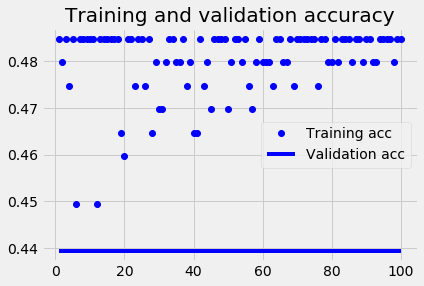

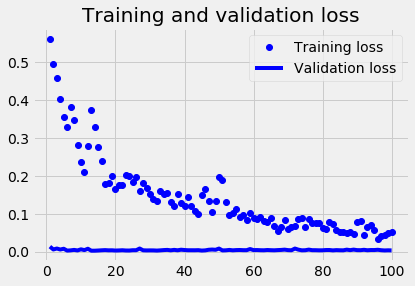

In [33]:
evaluate_my_fit(history)

In [34]:
train_predictions = model.predict(train_X)

# Train RMSE
metrics.mean_squared_error(train_Y.reshape(train_Y.shape[0], train_Y.shape[1] * train_Y.shape[2]),
                           train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2]))

0.0310987359597842

In [35]:
test_predictions = model.predict(eval_X)

# Test RMSE
metrics.mean_squared_error(eval_Y.reshape(eval_Y.shape[0], eval_Y.shape[1] * eval_Y.shape[2]),
                           test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[1] * train_predictions.shape[2]))

0.042355426384184984

### Naïve RNN

Naïve RNN

The absolute most basic kind of RNN, these RNNs tend to forget very quickly. Probably a good baseline to have a LSTM beat

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

In [39]:
model = Sequential()

model.add(SimpleRNN(32, input_shape=(22, 6), return_sequences=True))
model.add(Dense(1))

model.compile(optimizer='rmsprop', 
              loss='mse',
              metrics=['acc'])

history = model.fit(train_X, train_Y, 
                    epochs=100, batch_size=16,
                    validation_split=0.2)

Train on 9 samples, validate on 3 samples
Epoch 1/100
9/9 [==============================] - 0s 34ms/step - loss: 0.8506 - acc: 0.4040 - val_loss: 0.0919 - val_acc: 0.4091
Epoch 2/100
9/9 [==============================] - 0s 1ms/step - loss: 0.7288 - acc: 0.4141 - val_loss: 0.0840 - val_acc: 0.4091
Epoch 3/100
9/9 [==============================] - 0s 1ms/step - loss: 0.6560 - acc: 0.4343 - val_loss: 0.0802 - val_acc: 0.4091
Epoch 4/100
9/9 [==============================] - 0s 2ms/step - loss: 0.6013 - acc: 0.4444 - val_loss: 0.0776 - val_acc: 0.4242
Epoch 5/100
9/9 [==============================] - 0s 2ms/step - loss: 0.5565 - acc: 0.4495 - val_loss: 0.0758 - val_acc: 0.4242
Epoch 6/100
9/9 [==============================] - 0s 1ms/step - loss: 0.5183 - acc: 0.4545 - val_loss: 0.0744 - val_acc: 0.4242
Epoch 7/100
9/9 [==============================] - 0s 1ms/step - loss: 0.4847 - acc: 0.4545 - val_loss: 0.0733 - val_acc: 0.4394
Epoch 8/100
9/9 [==============================] - 0s 

Epoch 64/100
9/9 [==============================] - 0s 1ms/step - loss: 0.0338 - acc: 0.4848 - val_loss: 0.0301 - val_acc: 0.4091
Epoch 65/100
9/9 [==============================] - 0s 1ms/step - loss: 0.0326 - acc: 0.4848 - val_loss: 0.0263 - val_acc: 0.4242
Epoch 66/100
9/9 [==============================] - 0s 1ms/step - loss: 0.0316 - acc: 0.4848 - val_loss: 0.0312 - val_acc: 0.4091
Epoch 67/100
9/9 [==============================] - 0s 1ms/step - loss: 0.0308 - acc: 0.4848 - val_loss: 0.0254 - val_acc: 0.4394
Epoch 68/100
9/9 [==============================] - 0s 1ms/step - loss: 0.0301 - acc: 0.4848 - val_loss: 0.0345 - val_acc: 0.4091
Epoch 69/100
9/9 [==============================] - 0s 1ms/step - loss: 0.0298 - acc: 0.4848 - val_loss: 0.0251 - val_acc: 0.4394
Epoch 70/100
9/9 [==============================] - 0s 1ms/step - loss: 0.0294 - acc: 0.4848 - val_loss: 0.0356 - val_acc: 0.4091
Epoch 71/100
9/9 [==============================] - 0s 1ms/step - loss: 0.0286 - acc: 0.48

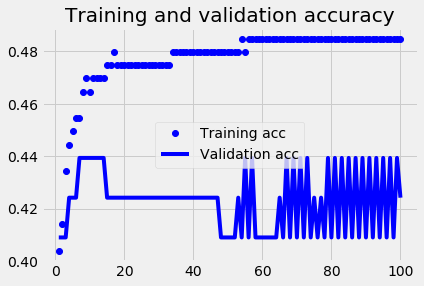

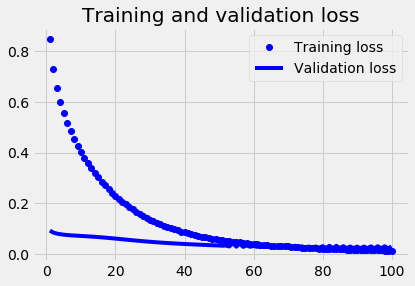

In [40]:
evaluate_my_fit(history)

In [41]:
train_predictions = model.predict(train_X)

# Train RMSE
metrics.mean_squared_error(train_Y.reshape(train_Y.shape[0], train_Y.shape[1] * train_Y.shape[2]),
                           train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2]))

0.016403408748535075

In [42]:
test_predictions = model.predict(eval_X)

# Test RMSE
metrics.mean_squared_error(eval_Y.reshape(eval_Y.shape[0], eval_Y.shape[1] * eval_Y.shape[2]),
                           test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[1] * train_predictions.shape[2]))

0.09831679195814175

### GRU

Gated recurrent unit (GRU)

Basically a cheaper to run version of LSTM, but trades this for less representational power

In [43]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [44]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(22,6),
                    return_sequences=True,
                    dropout=0.2,
                    recurrent_dropout=0.2))
model.add(Dense(1))

model.compile(optimizer=RMSprop(),
              loss='mse',
              metrics=['acc'])
history = model.fit(train_X, train_Y, 
                    epochs=100, batch_size=16,
                    validation_split=0.2)

Train on 9 samples, validate on 3 samples
Epoch 1/100
9/9 [==============================] - 1s 73ms/step - loss: 0.3852 - acc: 0.4444 - val_loss: 0.0496 - val_acc: 0.4394
Epoch 2/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2973 - acc: 0.4545 - val_loss: 0.0459 - val_acc: 0.4394
Epoch 3/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2171 - acc: 0.4747 - val_loss: 0.0389 - val_acc: 0.4394
Epoch 4/100
9/9 [==============================] - 0s 4ms/step - loss: 0.4160 - acc: 0.4545 - val_loss: 0.0320 - val_acc: 0.4394
Epoch 5/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2090 - acc: 0.4596 - val_loss: 0.0293 - val_acc: 0.4394
Epoch 6/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2494 - acc: 0.4697 - val_loss: 0.0284 - val_acc: 0.4394
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2422 - acc: 0.4495 - val_loss: 0.0268 - val_acc: 0.4394
Epoch 8/100
9/9 [==============================] - 0s 

Epoch 64/100
9/9 [==============================] - 0s 3ms/step - loss: 0.2482 - acc: 0.4798 - val_loss: 0.0355 - val_acc: 0.4394
Epoch 65/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1620 - acc: 0.4495 - val_loss: 0.0277 - val_acc: 0.4394
Epoch 66/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0948 - acc: 0.4697 - val_loss: 0.0274 - val_acc: 0.4394
Epoch 67/100
9/9 [==============================] - 0s 2ms/step - loss: 0.1166 - acc: 0.4596 - val_loss: 0.0191 - val_acc: 0.4394
Epoch 68/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0604 - acc: 0.4798 - val_loss: 0.0186 - val_acc: 0.4394
Epoch 69/100
9/9 [==============================] - 0s 3ms/step - loss: 0.1113 - acc: 0.4848 - val_loss: 0.0184 - val_acc: 0.4394
Epoch 70/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0818 - acc: 0.4697 - val_loss: 0.0217 - val_acc: 0.4394
Epoch 71/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0624 - acc: 0.47

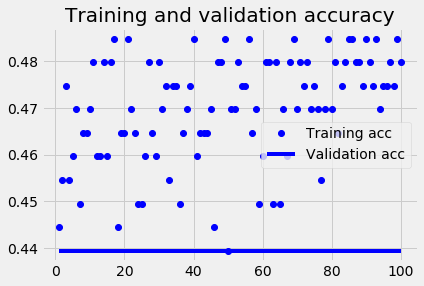

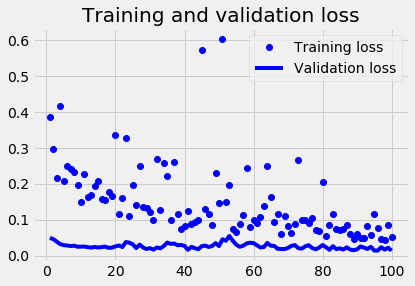

In [45]:
evaluate_my_fit(history)
# Why is this all over the place?????

In [46]:
train_predictions = model.predict(train_X)

# Train RMSE
metrics.mean_squared_error(train_Y.reshape(train_Y.shape[0], train_Y.shape[1] * train_Y.shape[2]),
                           train_predictions.reshape(train_predictions.shape[0], train_predictions.shape[1] * train_predictions.shape[2]))

0.03995650542282472

In [47]:
test_predictions = model.predict(eval_X)

# Test RMSE
metrics.mean_squared_error(eval_Y.reshape(eval_Y.shape[0], eval_Y.shape[1] * eval_Y.shape[2]),
                           test_predictions.reshape(test_predictions.shape[0], test_predictions.shape[1] * train_predictions.shape[2]))

0.06014295091646374

### CNN

1D Convnet

1D convnets have sometimes shown to be more efficient with data than similarly sized RNNs when dealing with small problems. Maybe that means they're a good application here? Each output timestep takes power from its neighbours, so this is assuming some sort of autoregression.

In [48]:
from keras.models import Sequential
from keras import layers

In [49]:
train_Y.shape

(12, 22, 1)

In [50]:
model = Sequential()
model.add(layers.Conv1D(filters=32, kernel_size=2,
                        activation='relu',
                        input_shape=(22,6)))
model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(1))
# 1D Convnets cannot return sequences, they converge to one value...
model.compile(optimizer='adam', 
              loss='mse',
              metrics=['acc'])

history = model.fit(train_X, train_Y.reshape(12, 22), 
                    epochs=100, batch_size=16,
                    validation_split=0.2)

ValueError: Error when checking target: expected dense_5 to have shape (1,) but got array with shape (22,)

### MLP

Multilayer Perceptron (MLP) 

In this case MLP refers to a feedforward set of dense layers, that's it. This is another really simple model that could be used as a baseline. However this kind of model has no memory.

In [ ]:
# MLP also have the problem of requiring some more thinking to be generative...

## Parametric

### ARIMA